# PIMA

This Machine Learning project determines if a patient has diabetes.

The dataset is filled with medical information of indian female patients.

## Summary

* Data visualisation
* Logistic Regression
* Decision Tree
* Random Forest

# Library used

In [31]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

# Oversampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Machine Learning Library
import joblib
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

# Data

In [32]:
data = pd.read_csv("./resources/diabetes.csv", encoding='utf-8', sep=',')
data.drop_duplicates()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Missing values

In [33]:
(data.isnull().sum()/data.shape[0])*100

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

There is no missing values in the data.

## Balance of Target data

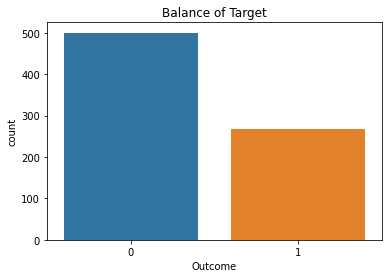

Unbalanced data on the 'Outcome' column:
0    500
1    268
Name: Outcome, dtype: int64


In [34]:
fig = sns.countplot(x="Outcome", data=data)
plt.title('Balance of Target')
plt.show()
print("Unbalanced data on the 'Outcome' column:")
print(data['Outcome'].value_counts())

The data is slightly imbalanced, this might be an issue for our machine learning models later on.

#### Oversampling the data

In [35]:
X = data
Y = np.array(data['Outcome'])
X.drop('Outcome', axis=1, inplace=True)
ros = RandomOverSampler(random_state=42)
data, y_resampled = ros.fit_resample(X,Y)
data['Outcome'] = y_resampled
print(sorted(Counter(y_resampled).items()), y_resampled.shape)

[(0, 500), (1, 500)] (1000,)


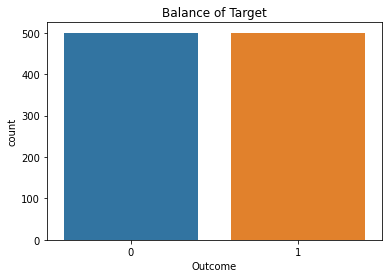

Unbalanced data on the 'Outcome' column:
1    500
0    500
Name: Outcome, dtype: int64


In [36]:
fig = sns.countplot(x="Outcome", data=data)
plt.title('Balance of Target')
plt.show()
print("Unbalanced data on the 'Outcome' column:")
print(data['Outcome'].value_counts())

## Outliers

In [37]:
fig = px.box(data, y= ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                        'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
fig.show()

The Insulin column has a lot of outliers, they might be the result of errors when entering the data.

A majority of the columns have anomalies : the value is sometimes too high or too low when it's not humanely possible, for example a BMI (Body Mass Index) equal to 0.

#### Removing outliers and anomalies

In [38]:
# Outliers
data.drop(data.index[(data["Insulin"] > 400)], axis=0, inplace=True)
# Anomalies
data.drop(data.index[(data["Glucose"] == 0)], axis=0, inplace=True)
data.drop(data.index[(data["BloodPressure"] == 0)], axis=0, inplace=True)
data.drop(data.index[(data["SkinThickness"] == 0)], axis=0, inplace=True)
data.drop(data.index[(data["Insulin"] == 0)], axis=0, inplace=True)
data.drop(data.index[(data["BMI"] == 0)], axis=0, inplace=True)
data.drop(data.index[(data["DiabetesPedigreeFunction"] == 0)], axis=0, inplace=True)
data.drop(data.index[(data["Age"] == 0)], axis=0, inplace=True)

## Correlation

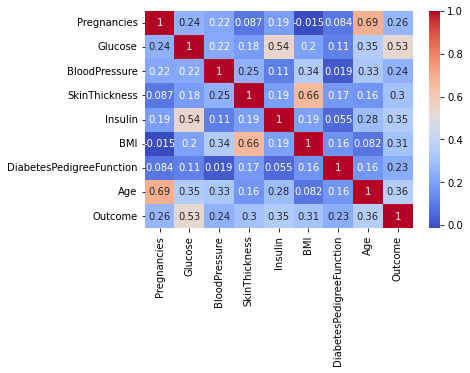

In [39]:
dataplot = sns.heatmap(data.corr(), cmap="coolwarm", annot=True)
plt.show()

## Pairplots

In [40]:
fig = px.scatter_matrix(data,
    dimensions=['Glucose', 'BloodPressure', 'DiabetesPedigreeFunction', 'BMI', 'Age'],
    color="Outcome")
fig.show()

## Distribution of characteristics among patients

By counting the number of patients depending on certain characteristics and using lineplots, we can see that the data is unbalanced on certain characteristics, which can affect our diagnosis. 

This information needs to be remembered when testing models. For example, we have a lot of younger women, they have 0 

#### Distribution of BloodPressure levels

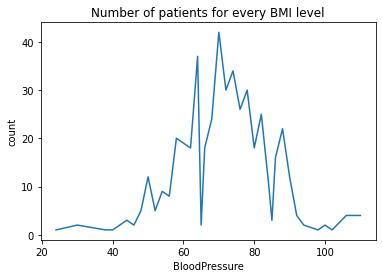

In [90]:
BP_data = data.groupby(['BloodPressure']).size().reset_index(name='count')
sns.lineplot(data=BP_data, x='BloodPressure', y='count')
plt.title('Number of patients for every BloodPressure level')
plt.show()

#### Distribution of Age

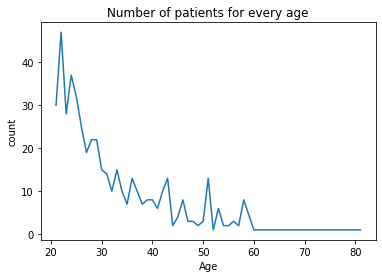

In [87]:
age_data = data.groupby(['Age']).size().reset_index(name='count')
sns.lineplot(data=age_data, x='Age', y='count')
plt.title('Number of patients for every age')
plt.show()

# Splitting data into training and testings sets

In [42]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
print('Patient characteristics columns:\n\n', X.head(), '\n')
print('Diabetes Outcome:\n\n', y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Patient characteristics columns:

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3             1       89             66             23       94  28.1   
4             0      137             40             35      168  43.1   
6             3       78             50             32       88  31.0   
14            5      166             72             19      175  25.8   
16            0      118             84             47      230  45.8   

    DiabetesPedigreeFunction  Age  
3                      0.167   21  
4                      2.288   33  
6                      0.248   26  
14                     0.587   51  
16                     0.551   31   

Diabetes Outcome:

 3     0
4     1
6     1
14    1
16    1
Name: Outcome, dtype: int64


# Logistic Regression

## Model Training

In [43]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

## Model testing

In [44]:
y_pred = LR.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0
 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1
 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1
 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0] 

Real values:

 911    1
939    1
25     1
987    1
95     0
      ..
134    0
243    1
617    0
886    1
70     1
Name: Outcome, Length: 143, dtype: int64


## Model Evaluation

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.79      0.74        70
           1       0.77      0.68      0.72        73

    accuracy                           0.73       143
   macro avg       0.74      0.74      0.73       143
weighted avg       0.74      0.73      0.73       143



In [46]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(LR, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 73.43 %

Accuracy score using cross validation: 76.73 %



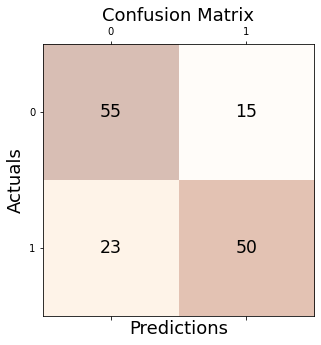

In [47]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Decision Tree

## Model Training

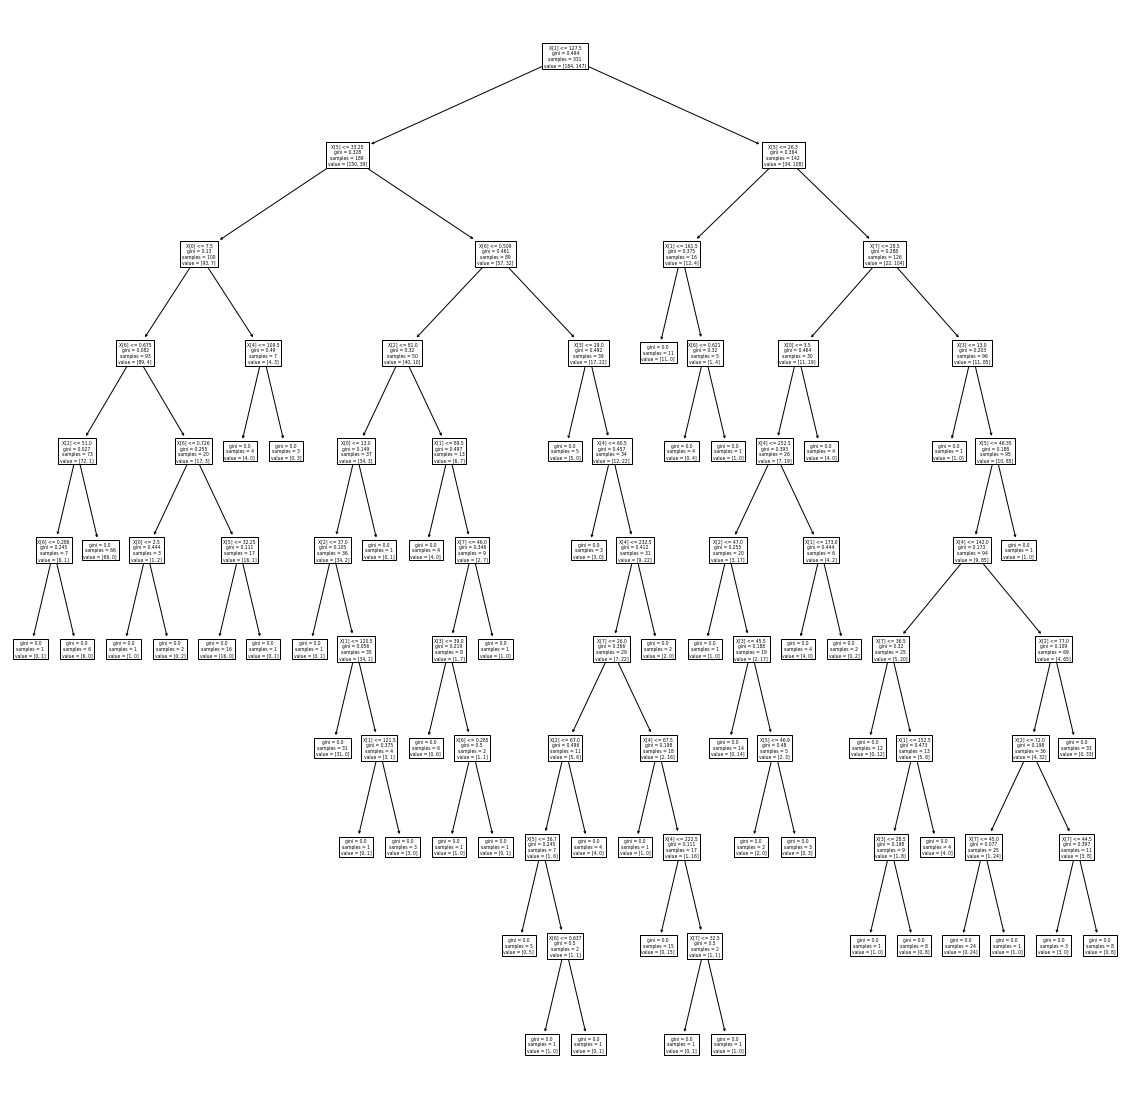

In [48]:
DT = DecisionTreeClassifier(criterion='gini', min_samples_split=2)
DT.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DT)
plt.show()

## Model Testing

In [49]:
y_pred = DT.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1
 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1
 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1] 

Real values:

 911    1
939    1
25     1
987    1
95     0
      ..
134    0
243    1
617    0
886    1
70     1
Name: Outcome, Length: 143, dtype: int64


## Model Evaluation

In [50]:
print("Classification report:", classification_report(y_test, y_pred))
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(DT, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Classification report:               precision    recall  f1-score   support

           0       0.88      0.74      0.81        70
           1       0.79      0.90      0.84        73

    accuracy                           0.83       143
   macro avg       0.83      0.82      0.82       143
weighted avg       0.83      0.83      0.82       143

Accuracy score: 82.52 %

Accuracy score using cross validation: 76.14 %



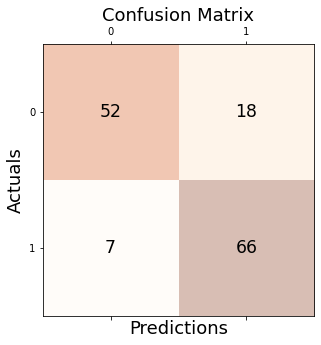

In [51]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Random Forest

## Model Training

In [52]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

## Model Testing

In [53]:
y_pred = RF.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0
 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0
 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0] 

Real values:

 911    1
939    1
25     1
987    1
95     0
      ..
134    0
243    1
617    0
886    1
70     1
Name: Outcome, Length: 143, dtype: int64


## Model Evaluation

In [54]:
print("Classification report:", classification_report(y_test, y_pred))
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(RF, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Classification report:               precision    recall  f1-score   support

           0       0.81      0.79      0.80        70
           1       0.80      0.82      0.81        73

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143

Accuracy score: 80.42 %

Accuracy score using cross validation: 85.19 %



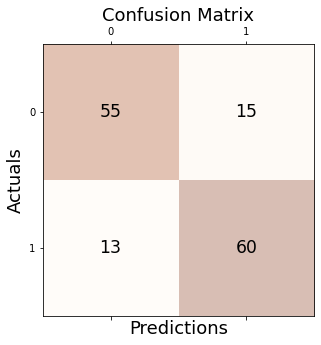

In [55]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# XGBoost

## Model Training

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [57]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
bst = xgb.train(param, dtrain, num_round)
bst.dump_model('dump.raw.txt')
f = open('dump.raw.txt', 'r')
print(f.read())

[21:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
booster[0]:
0:[Glucose<128] yes=1,no=2,missing=1
	1:[BMI<33.25] yes=3,no=4,missing=3
		3:[Pregnancies<8] yes=7,no=8,missing=7
			7:leaf=0.411023617
			8:leaf=0.121621616
		4:[DiabetesPedigreeFunction<0.509500027] yes=9,no=10,missing=9
			9:leaf=0.301435411
			10:leaf=0.0654

## Model Testing

In [58]:
probs_predictions = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in probs_predictions])
print("Predictions:\n\n", predictions, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0
 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0] 

Real values:

 911    1
939    1
25     1
987    1
95     0
      ..
134    0
243    1
617    0
886    1
70     1
Name: Outcome, Length: 143, dtype: int64


## Model Evaluation

In [59]:
print("Accuracy Score:", round(precision_score(y_test, predictions, average='macro')*100, 2), "%")

Accuracy Score: 77.71 %


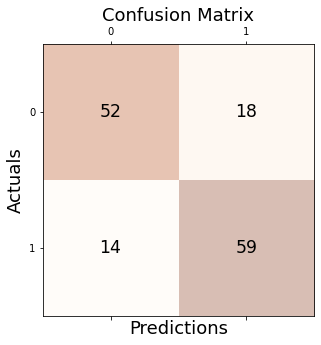

In [60]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Conclusion

We did some model testing before oversampling the database. 
The Logistic Regression and Random Forest models had the best accuracy score at the time.


After oversampling, we can see that the Decision Tree and Random Forest models have far better performance with an accuracy of 80% and even 85% for random forest.

Removing anomalies, such as characteristics equal to 0, increases the accuracy score of our Logistic Regression model.